<a href="https://colab.research.google.com/github/magicaltrap/clickbait_fastai/blob/master/clickbait_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup
How to run fastai library in Google Colab: https://course.fast.ai/start_colab.html

In [0]:
 !curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
path_clickbait = "/content/gdrive/My Drive/data/clickbait/"
path_clickbait_detection = "/content/gdrive/My Drive/data/clickbait/clickbait_detection/"

Mounted at /content/gdrive


In [0]:
from fastai import *
from fastai.text import *

import pandas as pd

# Language Model

## Create TextDataBunch
We load our combined labeled/unlabeled .csv file (that we created in the separate preprocessed_csv.ipynb file) into a TextDataBunch. fastai's TextDataBunch is a very useful tool and does for us:

*   data storage
*   splitting our data into training and validation sets
*   automatic tokenization and numericalization 
*   etc.

We will use the labeled and unlabeled "postTexts" (Twitter posts) later to fine-tune our language model (see below).

In [0]:
data_lm = (TextList.from_csv(path_clickbait, 'data/lab_unlab_text.csv', cols="postText")
           .split_by_rand_pct()
           .label_for_lm()
           .databunch())

The TextDataBunch also creates a vocabulary dictionary for us. Tokens like "xxunk" (unkwown words) or "xxbos" (beginning of sentence) are fastai's special tokens. Our clickbait vocabulary consists of 19000 words

In [0]:
data_lm.vocab.itos[:15], len(data_lm.vocab.itos)

(['xxunk',
  'xxpad',
  'xxbos',
  'xxeos',
  'xxfld',
  'xxmaj',
  'xxup',
  'xxrep',
  'xxwrep',
  'the',
  'to',
  'in',
  'a',
  ',',
  'of'],
 19000)

One Twitter postText example from the training set

In [0]:
data_lm.train_ds[0][0]

Text xxbos xxmaj facts that will be truly upsetting to ' 90s girls

One Twitter postText example from the validation set

In [0]:
data_lm.valid_ds[0][0]

Text xxbos xxmaj hungarian border guards ' taking selfies with beaten migrants '

In [0]:
len(data_lm.vocab.itos), len(data_lm.train_ds), len(data_lm.valid_ds)

(19000, 79598, 19899)

More examples:

In [0]:
data_lm.show_batch()

idx,text
0,""" xxbos xxmaj the dictionary left no uncertainty as to whom "" xxunk "" refers . xxbos xxmaj in the latest airline episode captured on video , a xxmaj delta pilot can be seen xxunk a woman to break up a fight xxbos xxmaj hacker releases new episodes of ' xxmaj orange xxmaj is the xxmaj new xxmaj black ' xxbos xxmaj taylor xxmaj bennett speaks on branding , building"
1,"xxbos xxmaj crocodile leaps from the water to attack an elephant in xxmaj malawi xxbos xxmaj talking - car safety mandate hits unexpected opposition xxbos xxmaj first woman to officially run xxmaj boston xxmaj marathon finishes race again at 70 . xxbos xxup doj is xxunk that xxmaj arpaio ’s fate will be decided by a federal judge , not by a jury of his peers . xxbos xxmaj on"
2,"xxmaj suspected chemical attack in xxmaj syria “ an xxunk to humanity ” xxbos xxmaj inside xxunk 's complicated legal situation xxbos xxmaj it was the third time he was hit by a thrown ball in just that trip around the bases . xxbos xxmaj the xxmaj donald xxmaj trump of xxmaj brazil declares war on graffiti xxbos xxmaj president xxmaj trump : "" i now have responsibility "" when"
3,"days . \n \n xxmaj gonzaga 's average ? 22 years , 150 days . xxbos xxmaj tennessee school bus driver to be arraigned in crash that killed 6 children xxbos xxmaj watch the video for xxmaj iggy xxmaj azalea 's new single "" xxmaj mo xxmaj bounce . "" xxbos xxmaj trump starts healthcare judgment day by attacking conservative xxmaj freedom xxmaj caucus in tweets xxbos a xxmaj"
4,"area xxmaj monday night , paralyzing blizzard from xxmaj new xxmaj york to xxmaj boston xxbos 22 puns that went xxup way too far xxbos xxmaj three bachelors played a key , behind - the - scenes role in building the # xxup bjp 's victory in xxmaj uttar xxmaj pradesh . xxbos xxmaj this xxunk went to a museum for his third birthday and he looked very happy xxbos"


In [0]:
x,y = next(iter(data_lm.train_dl))
example = x[:20,:20].cpu()
texts = pd.DataFrame([data_lm.train_ds.vocab.textify(l).split(' ') for l in example])
texts

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,his,career,xxunk,at,xxup,nyu,xxbos,xxmaj,knife,crime,up,14,%,because,gang,warfare,is,becoming,',embedded
1,his,first,day,on,the,bench,",",xxmaj,justice,xxmaj,neil,xxmaj,gorsuch,was,an,exceptionally,active,xxunk,xxbos,xxmaj
2,it,comes,to,xxmaj,syria,xxbos,xxmaj,could,xxmaj,marshawn,xxmaj,lynch,be,returning,to,the,xxup,nfl,?,xxbos
3,raised,$,"25,000",for,victims,of,the,xxmaj,london,attack,in,48,hours,xxbos,xxmaj,lone,wolf,or,soldier,of
4,xxmaj,greensboro,church,selling,xxmaj,syracuse,vs.,xxup,unc,-,xxmaj,greensboro,shirts,ahead,of,xxup,xxunk,game,#,marchmadness
5,xxup,us,politicians,xxunk,xxunk,xxbos,xxmaj,fit,for,a,king,xxbos,“,xxmaj,it,is,not,compassionate,",",but
6,shows,about,high,school,football,xxbos,xxmaj,is,this,the,',master,switch,',that,prevents,xxmaj,parkinson,'s,disease
7,looking,for,a,practical,car,?,xxmaj,these,are,the,best,ones,to,get,in,2017,xxbos,xxmaj,falcons,center
8,xxunk,xxbos,xxmaj,analysis,:,xxmaj,trump,kills,xxup,tpp,",",giving,xxmaj,china,its,first,big,win,xxbos,xxmaj
9,xxbos,xxmaj,alexander,xxmaj,hamilton,'s,letters,to,be,xxunk,in,xxup,nyc,xxbos,#,xxup,icymi,:,xxmaj,how


### Save TextDataBunch

In [0]:
data_lm.save(path_clickbait_detection + "lm_databunch")

In [0]:
data_lm = load_data(path_clickbait_detection, "lm_databunch")

## Create Language Model
We will download a pre-trained "AWD_LSTM" model ([Merity et al. 2017](https://arxiv.org/abs/1708.02182)) which is already trained on the big [wikitext-103 dataset](https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/). The "wikitext-103" dataset is a collection of over 100 million tokens extracted from a set of verified articles on Wikipedia. This means that this model has already "knowledge" / "understanding" of the English language. We can now use (besides our labeled dataset) also our unlabeled clickbait dataset to fine-tune the pre-trained language model. The language of Wikipedia articles may be slightly different to our language in clickbait Twitter articles, so we train and feed the AWD_LSTM model our clickbait dataset to adapt it further to the clickbait task (and the specific clickbait language).

In [0]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

**Specifictions of our AWD_LSTM language model:**

In [0]:
learn_lm.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(19000, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(19000, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=19000, bias=True)
    (output_dp): RNNDropout()
  )
)

### Fine-tune the Language Model

Use fastai's [`lr_find()`](https://docs.fast.ai/basic_train.html#lr_find) method to find an optimal learning rate for training our language model.

In [0]:
learn_lm.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


This plots different learning rates in regard to our loss. This will help us to find a good learning rate which is not too small but also not too big

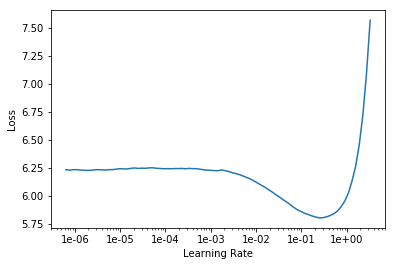

In [0]:
learn_lm.recorder.plot()

We now train our model with Leslie Smith's [1cycle policy](https://arxiv.org/pdf/1803.09820.pdf). In short what this policy does: The learning rate (and momentum) can increase and decrease during training which makes training the model very efficient. This way, we can avoid the case when the learning rate is too small (it takes a long time before our models finds the minimum of our loss function) or when the learning rate is too big (risk of overshooting and never finding the loss minimum). [More details](https://docs.fast.ai/callbacks.one_cycle.html#What-is-1cycle?) to the 1cycle policy.

In [0]:
learn_lm.fit_one_cycle(1, max_lr=1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,4.296512,4.103268,0.322673,02:34


Always save your models first before further training so you can still load them later again. Because once you trained your model too much (overfitting for example), there is no way back.

In [0]:
#saves the model in a "models" folder where the lm_databunch is located 
learn_lm.save("lm_1")

In [0]:
learn_lm.load("lm_1");

[Unfreeze()](https://docs.fast.ai/basic_train.html#Learner.unfreeze) our model so we can train all layers of the model (previously we could only train the later layers). Let's train it for a few epochs until our accurarcy stops improving.

In [0]:
learn_lm.unfreeze()

In [0]:
learn_lm.fit_one_cycle(5, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,3.803999,3.858396,0.351019,03:11
1,3.640860,3.747136,0.361687,03:10
2,3.390923,3.687510,0.369468,03:10
3,3.126921,3.689662,0.371002,03:11
4,2.948632,3.711466,0.370819,03:10


One interesting note that I learnt during fastai's Deep Learning course: How many epochs should you train the model before it starts overfitting? According to fastai's Jeremy Howard, you start to overfit your model when **the accuracy/error rate is getting worse (and not when the training loss is smaller than the validation loss!)**. Here is the excerpt:


---


*So the only thing that tells you that you’re overfitting is that the error rate improves for a while and then starts getting worse again. You will see a lot of people, even people that claim to understand machine learning, tell you that if your training loss is lower than your validation loss, then you are overfitting. As you will learn today in more detail and during the rest of course, that is absolutely not true.*

*Any model that is trained correctly will always have train loss lower than validation loss.*

*That is not a sign of overfitting. That is not a sign you’ve done something wrong. That is a sign you have done something right. The sign that you’re overfitting is that your error starts getting worse, because that’s what you care about. You want your model to have a low error. So as long as you’re training and your model error is improving, you’re not overfitting.*


---



[Source](https://forums.fast.ai/t/loss-over-fit-under-fit/32257/4)

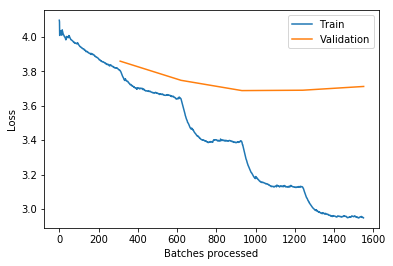

In [0]:
learn_lm.recorder.plot_losses()

In [0]:
learn_lm.save("lm_2")

**Save the encoder, we will use that for our classifier later**

In [0]:
learn_lm.save_encoder("lm_2_enc")

In [0]:
learn_lm.load("lm_2");

Let's see if our language model ca produce some sentences

In [0]:
#test what our language model predicts
learn_lm.predict("Write a clickbait Twitter post:", n_words=20)

'Write a clickbait Twitter post: Xbox and worrying ? Department of Health calls add Hud xxbos How Putin promised'

# Classifier

## Create TextClasDataBunch
We are loading now a `TextClasDataBunch` for our classifier. We will only use the labeled data (`modified_labels_text.csv`). We define the vocabulary of the language model (`data_lm.vocab`) in the vocab parameter of the `TextClasDataBunch`.

In [0]:
data_clas = TextClasDataBunch.from_csv(path=path_clickbait, csv_name="data/modified_labels_text.csv", vocab=data_lm.vocab, bs=64)

### Save TextClasDataBunch

In [0]:
data_clas.save(path_clickbait_detection + "clas_databunch")

In [0]:
data_clas = load_data(path_clickbait_detection, "clas_databunch", bs=64)

In [0]:
data_clas.show_batch()

text,target
xxbos 1 . xxmaj browns : ? ? \n 2 . 49ers : ? ? \n 3 . xxmaj bears : xxmaj jonathan xxmaj allen \n 4 . xxmaj jaguars : xxmaj jamal xxmaj adams \n 5 . xxmaj titans : xxmaj mike xxmaj williams \n 6 - 32 : ( xxmaj in ),no-clickbait
"xxbos xxmaj the latest xxmaj uber mess ? xxmaj oh , just \n 1 . xxmaj their top brass , \n 2 . xxmaj in a * failed cover - up * \n 3 . xxmaj involving * escorts * \n xxmaj oh yes :",clickbait
xxbos xxmaj wooden xxmaj watch is back as we rank the leading xxup xxunk contenders : \n \n 1 . xxmaj josh xxmaj hart \n 2 . xxmaj lonzo xxmaj ball \n 3 . xxmaj frank xxmaj mason xxup iii \n xxmaj the rest :,no-clickbait
xxbos xxup right xxup now : xxmaj tune in to xxmaj fox xxmaj news xxmaj channel for an all - new ' xxmaj legends & & xxmaj lies : xxmaj the xxmaj patriots ' featuring ' xxmaj forgotten xxmaj heroes . ',no-clickbait
xxbos xxup icymi : xxmaj the xxup nfl xxup mvp race is w xxrep 4 i de open . \n \n xxmaj but a certain xxmaj west xxmaj coast xxup qb is making a strong case at xxmaj no . 1 :,clickbait


## Create Clickbait Classifier

Now we create a model that can classify Twitter posts as clickbait or no-clickbait. Load the encoder that we saved from the language model earlier.

In [0]:
learn_clas = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.3)
learn_clas.load_encoder("lm_2_enc")
learn_clas.freeze()

In [0]:
learn_clas.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


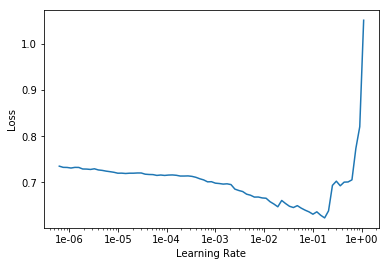

In [0]:
learn_clas.recorder.plot()

### Fine-Tune the Language Model

Again train the model a bit further (with `freeze_to()` / `unfreeze()` and the 1cycle policy for a few epochs).

In [0]:
learn_clas.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.450831,0.392339,0.815499,00:13


In [0]:
learn_clas.save("clas_1")

In [0]:
learn_clas.load("clas_1");

In [0]:
learn_clas.freeze_to(-2)

In [0]:
learn_clas.fit_one_cycle(1, 5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.364886,0.358481,0.840647,00:17


In [0]:
learn_clas.save("clas_2")

In [0]:
learn_clas.load("clas_2");

In [0]:
learn_clas.freeze_to(-3)
learn_clas.fit_one_cycle(1, 1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.347342,0.357151,0.845522,00:28


In [0]:
learn_clas.save("clas_3")

In [0]:
learn_clas.load("clas_3");

In [0]:
learn_clas.unfreeze()
learn_clas.fit_one_cycle(3, 5e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.282473,0.371435,0.846805,00:37
1,0.221737,0.408474,0.843983,00:35
2,0.119525,0.453525,0.843726,00:36


Accuracy us going down with unfreeze() and further training, so let's load "clas_3" model again and just train one more epoch. 

In [0]:
learn_clas.load("clas_3");

In [0]:
learn_clas.unfreeze()
learn_clas.fit_one_cycle(1, 5e-4)

epoch,train_loss,valid_loss,accuracy,time
0,0.282856,0.362761,0.845266,00:36


In [0]:
learn_clas.save("clas_4")

**The current state of the art models have a accuracy of 0.855 (as of August 2019), so we are very close and within one percent with our model that was only trained in less than an hour! This is the power of Transfer Learning in NLP!**
https://www.clickbait-challenge.org/

# Metrics

In [0]:
preds, y, losses = learn_clas.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn_clas, preds, y, losses)

## Confusion Matrix

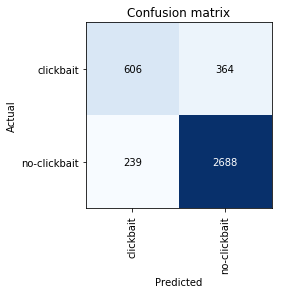

In [0]:
interp.plot_confusion_matrix()

## Precision, Recall, F1

In [0]:
TP = 606
TN = 2688
FP = 239
FN = 364

In [0]:
precision = TP/(TP+FP)
recall = TP/(TP+FN)
F1 = 2*((precision*recall)/(precision+recall))

precision, recall, F1

(0.7171597633136094, 0.6247422680412371, 0.6677685950413224)

## Accurary and Error Rate

In [0]:
accuracy(preds, y), error_rate(preds, y)

(tensor(0.8453), tensor(0.1547))

# Clickbait Detection Tests

Let's see if our model can accurately detect clickbait posts or not (I took some examples from the unlabeled dataset).

In [0]:
learn_clas.predict("Are high-end, big-budget films the future of fashion advertising?")

(Category no-clickbait, tensor(1), tensor([0.4308, 0.5692]))

In [0]:
learn_clas.predict("Can You Guess The Disney Movie By The Shoes?")

(Category clickbait, tensor(0), tensor([0.9654, 0.0346]))

In [0]:
learn_clas.predict("17 sibling horror stories guaranteed to shock you")

(Category clickbait, tensor(0), tensor([0.9906, 0.0094]))

In [0]:
learn_clas.predict("Donald Trump and his wife, Melania, are scheduled to arrive at the White House around 11 a.m. today")

(Category no-clickbait, tensor(1), tensor([0.0186, 0.9814]))

In [0]:
learn_clas.predict("America's pensions, endowments and foundations are souring on hedge funds")

(Category no-clickbait, tensor(1), tensor([0.0491, 0.9509]))

In [0]:
learn_clas.predict("BREAKING: Republican hold: Ron Johnson re-elected to Senate in Wisconsin  #CNNElection")

(Category no-clickbait, tensor(1), tensor([0.0093, 0.9907]))

In [0]:
learn_clas.predict("Check that out!!! 😱😱😱😱😱😱😱😱😱😱😱😱😱😱")

(Category clickbait, tensor(0), tensor([0.9128, 0.0872]))

In [0]:
learn_clas.predict("12 Reasons Why You Are Still Single")

(Category clickbait, tensor(0), tensor([0.9943, 0.0057]))

**Results:**
We observe that our classifier can detect clickbait or no-clickbait posts with high confidence (probability over 0.9). And in the case were the classification is abit ambigious (**"Are high-end, big-budget films the future of fashion advertising?"**) it outputs a balanced probability (`tensor([0.4308, 0.5692]))`